This script is designed as supporting material for the paper:
A Data-driven approach to the Fraction of Broken Waves
Australasian Coasts and Ports Conference - 2019
Caio E. Stringari

In [12]:
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
#
# SCRIPT   : predict_qb.py
# POURPOSE : predict Qb using Hs, Tp and profile.
#
# AUTHOR   : Caio Eadi Stringari
# EMAIL    : Caio.EadiStringari@uon.edu.au
#
# v1.0     : 06/09/2018 [Caio Stringari]
#
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------

# 1 - Imports

Here, we import all the tools we need

In [13]:
import os
import sys
import subprocess

from matplotlib.dates import date2num

from scipy.optimize import curve_fit

import textwrap

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# eXtreme Gradient Boosting
import xgboost as xgb
from xgboost import plot_tree

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

Set matplotlib and seaborn for better looking plots

In [14]:
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {'axes.linewidth': 2,
                        'legend.frameon': True,
                        'axes.facecolor': "#E9E9F1",
                        'grid.color': "w"})
mpl.rcParams['axes.linewidth'] = 2

# 2 - Functions

Lets define some useful functions. They are mostly for plotting.

In [18]:
def plot_prediction(dfm, dfp, y_pred, letter="a)", location="beach"):
    """
    Plot Qb predictions.

    ----------
    Args:
        dfm (Mandatory [pandas.DataFrame]): input data.

        dfp (Mandatory [pandas.DataFrame]): input data for preditions

        ypred (Mandatory [pandas.DataFrame]): predictions array.

        location (Optional [str]): Location name. Default is "Beach"
        
        letter (Optional [str]): Letter for the plot. Default is "a)"

    ----------
    Returns:
        ax, fig (Mandatory [mpl.figure]): axes and figures.

    """

    # plot
    fig, ax = plt.subplots(figsize=(6, 6))

    # scatter MLP data
    ax.scatter((dfp["mean_water_depth"] - dfp["mean_water_depth"].min()) /
               dfp["Hs"].max(), dfp["Qb"], 100,
               color="k", marker="+", label="Eq. 5", linewidth=3,
               alpha=0.75)

    # Scatter XGB predictions
    yplot = (dfm["mean_water_depth"] - dfm["mean_water_depth"].min()) / \
        dfm["Hs"].max()
    sorts = np.argsort(yplot.values)
    yplot = yplot.values[sorts]
    y_pred = y_pred[sorts]
    ax.scatter(yplot, y_pred, 100, color="r",
               label="XGB")

    # add letters
    ax.text(0.025, 0.05, "{})".format(letters[k]),
            transform=ax.transAxes, ha="left",
            va="center", bbox=bbox, zorder=10)

    ax.set_title(location.replace("_", " "))

    ax.set_xlabel(r"$h/H_{{m_0}_{\infty}}$ $[-]$")
    ax.set_ylabel("Qb [-]")

    leg = ax.legend(loc=1)
    leg.get_frame().set_color("w")

    ax.grid(color="w", lw=2, ls="-")

    ax.set_xlim(0, 2.)
    ax.set_ylim(bottom=0)

    fig.tight_layout()

    sns.despine()

    plt.show()

    return ax, fig

# 3 - Qb Prediction

In [22]:
# read all data
df_raw = pd.read_csv("stringari_and_power_2019.csv")

# selected locations
locations = ["Seven_Mile_Beach", "Moreton_Island",
             "One_Mile_Beach", "Werri_Beach"]

# selected days
days = [14, 20, 4, 15] 

# some plottinge details
letters = ["a", "b", "c", "d"]
bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)



  -- Location left out: Seven_Mile_Beach
     X: (3055, 3)
     y: (3055,)
     r-score: 0.9739682326716178
     rmse: 0.05841291685967843
     mae: 0.04647451630005469


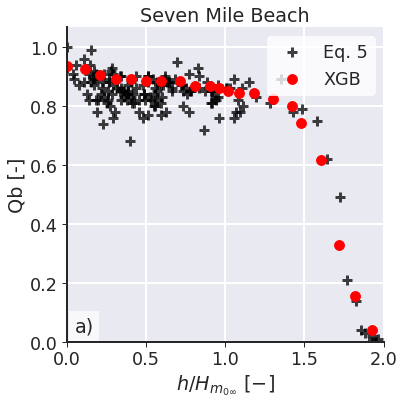



  -- Location left out: Moreton_Island
     X: (3233, 3)
     y: (3233,)
     r-score: 0.9714940968320903
     rmse: 0.06185722722213657
     mae: 0.048074829969008144


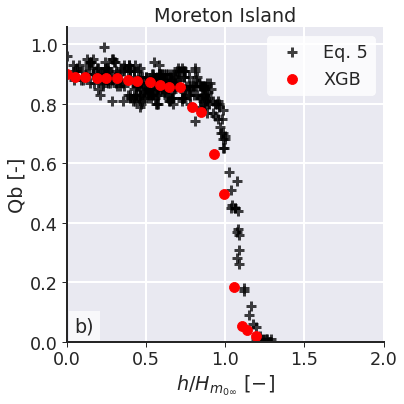



  -- Location left out: One_Mile_Beach
     X: (2790, 3)
     y: (2790,)
     r-score: 0.967053906371948
     rmse: 0.06356521344804425
     mae: 0.04793792350317842


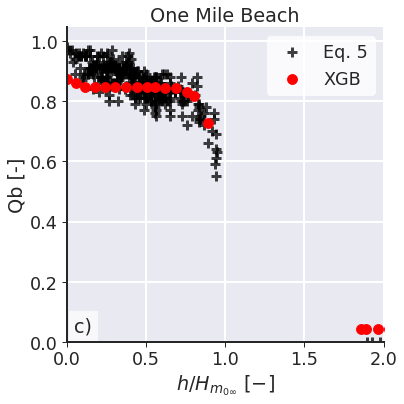



  -- Location left out: Werri_Beach
     X: (3238, 3)
     y: (3238,)
     r-score: 0.9670622339642353
     rmse: 0.05797249340689827
     mae: 0.045822096349280556


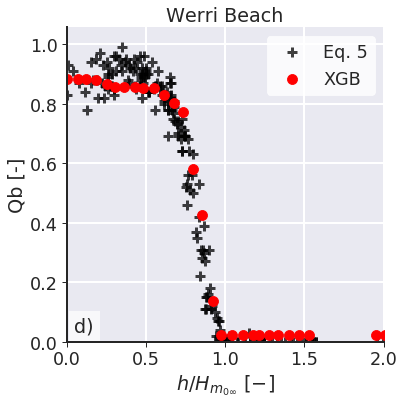

In [27]:
# Leave-one-out cross-validation.
# We loop over the locations, selected the data for three locations
# and predict Qb for the forth

k = 0
for location, day in zip(locations, days):

    # drop prediction location data
    df = df_raw.loc[df_raw["location"] != location]

    # create arrays
    X = df[["mean_water_depth", "Hs", "Tp"]].values
    y = df["Qb"].values

    print("\n")
    print("  -- Location left out: {}".format(location))
    print("     X: {}".format(X.shape))
    print("     y: {}".format(y.shape))
    # print("\n")

    # split
    X_train, X_test, y_train, y_test, = train_test_split(X, y,
                                                         shuffle=True,
                                                         random_state=42,
                                                         train_size=0.8,
                                                         test_size=0.2)

    # scale each feature from 0 to 1
    scaler = MinMaxScaler().fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # build the model
    model = xgb.XGBRegressor(n_estimators=32, max_depth=4,
                             learning_rate=0.1, subsample=0.33)
    train_model = model.fit(X_train, y_train)

    # predict new data
    y_pred = train_model.predict(X_test)

    # model scores
    print("     r-score: {}".format(pearsonr(y_test, y_pred)[0]))
    print("     rmse: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("     mae: {}".format(mean_absolute_error(y_test, y_pred)))
    #r2.append()
    #rmse.append()
    #mae.append()

    # simulate
    dfm = df_raw.loc[df_raw["location"] == location]
    dfm = dfm.loc[dfm["day"] == day]
    dfp = dfm.copy()

    # bin data
    bins = np.arange(dfm["mean_water_depth"].min(),
                     dfm["mean_water_depth"].max(), 0.1)
    groups = pd.cut(dfm["mean_water_depth"], bins)
    depth_means = []
    for g in groups:
        try:
            depth_means.append(g.left)
        except Exception:
            depth_means.append(0)
    dfm["depth"] = depth_means
    dfm = dfm.groupby("depth").mean()

    # predictors
    Xm = dfm[["mean_water_depth", "Hs", "Tp"]].values

    # scale
    Xm = scaler.transform(Xm)
    Xm[:, 1] = round(Xm[0, 1], 2)
    Xm[:, 2] = round(Xm[0, 2], 2)

    # predict
    y_true = dfm["Qb"].values
    y_pred = model.predict(Xm)

    plot_prediction(dfm, dfp, y_pred, letter=letters[k],
                    location=locations[k])
    
    k += 1

